**1.背景** <br>
  2020年1月新型冠状病毒（以下简称新冠）肺炎在极短时间内就在全球范围内大规模流行，由于新冠病毒的传播速度快、致死率较高，世界卫生组织称新冠是百年一遇的人类公敌。自新冠肺炎爆发以来，面对社会对疫情信息的迫切需求，各级政府部门通过多种渠道及时发布第一手相关数据，许多组织和个人也迅速行动，利用多种分析手段为公众提供疫情数据的解读分析，以消除公众的恐慌情绪，提高人们的自我防护意识，配合政府的防疫措施，为我国最终打赢疫情防控阻击战发挥了巨大的推动作用。<br>
  本新冠疫情的数据来自COVID19 Global Forecasting，并经过适当处理，通过拟合全球数据预测未来日期在世界各地不同地点的累计确诊 COVID19病例数，以及由此产生的死亡人数。通过预测疫情传播的演变，来分析确定哪些因素影响COVID19的传播，。<br>
  
**2.数据说明** <br>
  本新冠疫情的数据来自COVID19 Global Forecasting，涵盖了163个国家及众多各地区从2020年起将持续近2个月的疫情数据，通过拟合全球数据预测未来日期在世界各地不同地点的累计确诊 COVID19病例数，以及由此产生的死亡人数。通过预测疫情传播的演变，来分析确定哪些因素影响COVID19的传播。<br>

* train.csv 训练数据（2020-01-22至2020-03-31）

| Id（序号） | Province_State（省份，可为空） | Country_Region（国家/地区） | Date（日期） | ConfirmedCases（确诊人数） | Fatalities（死亡人数） |
| ---------- | ------------------------------ | --------------------------- | ------------ | -------------------------- | ---------------------- |
| 1          |                                | Afghanistan                 | 2020-01-22   | 0.0                        | 0.0                    |
| 4930       | Anhui                          | China                       | 2020-02-20   | 987.0                      | 6.0                    |

* test.csv 测试数据（2020-03-19至2020-04-30）

| ForecastId（预测id） | Province_State（省份，可为空） | Country_Region（国家/地区） | Date(日期) |
| -------------------- | ------------------------------ | --------------------------- | ---------- |
| 1                    |                                | Afghanistan                 | 2020-03-19 |
| 2265                 | Fujian                         | China                       | 2020-04-16 |




**3.目标**<br>
1.对疫情数据进行简单的统计。<br>
2.可视化展示新冠疫情的时空变化情况。<br>
4.对单个国家的疫情变化情况进行分析和预测。<br>

**4.思路**<br>
一、探索性数据分析<br>
1.1. COVID-19全球发展趋势<br>
1.2. COVID-19国内发展趋势<br>
<br>
二、数据清洗<br>
2.1. 合并数据、过滤日期和缺失值<br>
2.2. 增加国家细节<br>
<br>
三、机器学习的预测<br>
3.1. 单个国家的线性回归<br>
3.2. 回归结果可视化<br>



### 探索性分析

In [2]:
# 导库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing  # 预处理模块
import time
from datetime import datetime  # 时间模块
from scipy import integrate, optimize
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff
from plotly import subplots
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)
# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV  # 随机搜索和网格搜索模块
from sklearn import linear_model  # 线性回归模型
from sklearn.metrics import mean_squared_error  #均方误差函数

In [3]:
# 设置中文相关字体
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]  ## mac
plt.rcParams['font.family'] = ['Arial Unicode MS']  ## mac
#plt.rcParams["font.sans-serif"] = ["SimHei"] ## win
#plt.rcParams['font.family']=['SimHei'] ## win
# 设置正常显示符号
plt.rcParams["axes.unicode_minus"] = False

In [4]:
# 读取数据，查看数据结构
import os

test = pd.read_csv('/Users/summer/PycharmProjects/LearningPython/dataset/test.csv')
train = pd.read_csv('/Users/summer/PycharmProjects/LearningPython/dataset/train.csv')
display(train.head())

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

In [19]:
# 查看训练数据的描述性信息
display(train.describe())

Id  ConfirmedCases    Fatalities
count  20580.000000    20580.000000  20580.000000
mean   14685.500000      514.939116     21.080952
std     8487.230117     4541.261768    287.758197
min        1.000000        0.000000      0.000000
25%     7335.750000        0.000000      0.000000
50%    14685.500000        0.000000      0.000000
75%    22035.250000       35.000000      0.000000
max    29370.000000   105792.000000  12428.000000

In [20]:
# 补充代码，统计训练数据中国家/地区Country_Region的总数并打印数值。 
# 统计测试数据中国家/地区数量
print("训练数据中国家/地区数量为: ", train["Country_Region"].nunique())
# 打印数据中初始日期和结束日期
print("训练数据中日期为", min(train['Date']), "至", max(train['Date']), ", 一共",
      pd.to_datetime(train['Date']).nunique(), "天数据。")

训练数据中国家/地区数量为:  173
训练数据中日期为 2020-01-22 至 2020-03-31 , 一共 70 天数据。


In [21]:
# 查看国际COVID-19疫情趋势（除中国外）
# 对日期进行分组，统计除中国外的其他地区的每一天的确诊/死亡病例的总和，要求使用agg方法进行聚合
# 统计除中国外的其他地区的每一天的确诊病例（ConfirmedCases）的总和
confirmed_total_date_noChina = train[train['Country_Region'] != 'China'].groupby('Date')['ConfirmedCases'].agg(
    'sum').to_frame()
# 统计除中国外的其他地区的每一天的死亡病例（Fatalities）的总和
fatalities_total_date_noChina = train[train['Country_Region'] != 'China'].groupby('Date')['Fatalities'].agg(
    'sum').to_frame()

Text(0.5, 0, '日期')

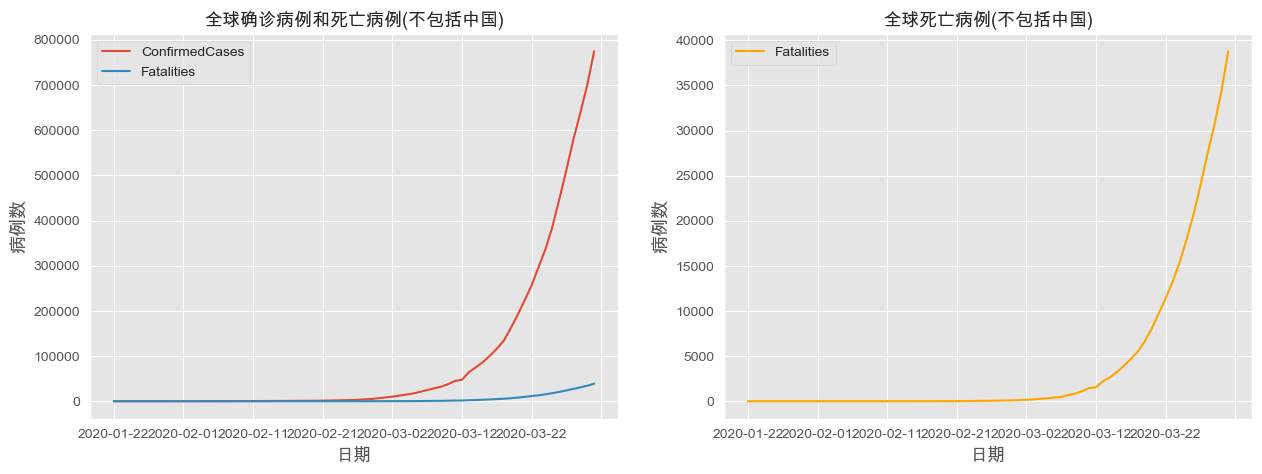

In [22]:
# 全球COVID-19疫情趋势可视化
# ax1同时显示全球确诊病例和死亡病例
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
total_date_noChina.plot(ax=ax1)
ax1.set_title("全球确诊病例和死亡病例(不包括中国)", size=13)
ax1.set_ylabel("病例数", size=13)
ax1.set_xlabel("日期", size=13)

# ax2显示全球死亡病例
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("全球死亡病例(不包括中国)", size=13)
ax2.set_ylabel("病例数", size=13)
ax2.set_xlabel("日期", size=13)

In [23]:
# 全球确诊情况的柱状图
# 横轴为时间， 纵轴为确诊人数，悬停位置显示 地区、确诊人数、死亡人数，颜色由地区决定
fig = px.bar(train, x='Date', y='ConfirmedCases', hover_data=['Fatalities'], color='Country_Region')
annotations = []

annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                        xanchor='left', yanchor='bottom',
                        text='Confirmed bar plot for each country',
                        font=dict(family='Arial',
                                  size=30,
                                  color='rgb(37,37,37)'),
                        showarrow=False))
fig.update_layout(annotations=annotations)  # 更新布局
fig.show()

In [24]:
# 全球死亡情况的柱状图
# 横轴为时间， 纵轴为死亡人数，悬停位置显示 地区、确诊人数、死亡人数，颜色由地区决定
fig = px.bar(train, x='Date', y='Fatalities', hover_data=['ConfirmedCases'], color='Country_Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                        xanchor='left', yanchor='bottom',
                        text='Death bar plot for each country',
                        font=dict(family='Arial',
                                  size=30,
                                  color='rgb(37,37,37)'),
                        showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [25]:
# 绘制国内的确诊情况的折线图，悬停位置显示省份、确诊人数、死亡人数
# 横轴为时间， 纵轴为确诊人数，悬停位置显示 省份、确诊人数、死亡人数，颜色由省份决定
fig = px.bar(train.loc[train['Country_Region'] == 'China'], x='Date', y='ConfirmedCases', hover_data=['Fatalities'],
             color='Province_State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                        xanchor='left', yanchor='bottom',
                        text='Confirmed bar plot for Mainland China',
                        font=dict(family='Arial',
                                  size=30,
                                  color='rgb(37,37,37)'),
                        showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [26]:
# 绘制国内的死亡情况的折线图
# 横轴为时间， 纵轴为确诊人数，悬停位置显示 地区、确诊人数、死亡人数，颜色由省份决定
# 标题：'Death bar plot for Mainland China'
fig = px.bar(train.loc[train['Country_Region'] == 'China'], x='Date', y='Fatalities', hover_data=['ConfirmedCases'],
             color='Province_State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                        xanchor='left', yanchor='bottom',
                        text='Death bar plot for Mainland China',
                        font=dict(family='Arial',
                                  size=30,
                                  color='rgb(37,37,37)'),
                        showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

通过上述分析COVID-19在国际和国内的发展趋势，可总结如下：<br>
由于我国是首个发布存在感染新冠肺炎病例的国家，所以COVID-19的爆发情况与世界其他国家不同。<br>
我国政府在相当短的时间内采取了强有力的措施，在病毒广泛传播的同时，已经能够控制感染的增加。<br>
国内疫情展示中可以看到3月之后曲线已经到达了一个停滞期，这意味着当时处于国内传染速度已经相对缓慢下来。<br>

### 数据清洗<br>
对数据集进行预处理准备，包括:<br>
(1)过滤日期：删除重复时间数据，训练数据中移除2020-03-18后确认的病例和死亡病例<br>
(2)数据合并重塑：合并训练数据和测试，以促进数据转换<br>
(3)缺失值：分析并修复缺失值<br>

In [27]:
train.head(5)

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

In [28]:
# 训练数据和测试数据中，有部分日期数据重合，对训练数据中的重合数据进行过滤
dates_overlap = ['2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
                 '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31']
# 使用isin搜索日期列表，并使用反布尔掩码进行过滤
train2 = train.loc[~train['Date'].isin(dates_overlap)]

# 数据重塑，对过滤后的训练数据和测试数据进行水平方向合并
all_data = pd.concat([train2, test], axis=0, sort=False)
display(all_data.loc[all_data['Date'] == '2020-03-19'])

Id Province_State Country_Region        Date  ConfirmedCases  \
0     NaN            NaN    Afghanistan  2020-03-19             NaN   
43    NaN            NaN        Albania  2020-03-19             NaN   
86    NaN            NaN        Algeria  2020-03-19             NaN   
129   NaN            NaN        Andorra  2020-03-19             NaN   
172   NaN            NaN         Angola  2020-03-19             NaN   
...    ..            ...            ...         ...             ...   
12427 NaN            NaN     Uzbekistan  2020-03-19             NaN   
12470 NaN            NaN      Venezuela  2020-03-19             NaN   
12513 NaN            NaN        Vietnam  2020-03-19             NaN   
12556 NaN            NaN         Zambia  2020-03-19             NaN   
12599 NaN            NaN       Zimbabwe  2020-03-19             NaN   

       Fatalities  ForecastId  
0             NaN         1.0  
43            NaN        44.0  
86            NaN        87.0  
129           NaN       130.0  
172           NaN       173.0  
...           ...         ...  
12427         NaN     12428.0  
12470         NaN     12471.0  
12513         NaN     12514.0  
12556         NaN     12557.0  
12599         NaN     12600.0  

[294 rows x 7 columns]

（1）合并后的数据集包括所有国家和日期<br>
（2）合并数据后，可以发现"ConfirmedCases" 和 "Fatalities"只有在2020-03-19之前有对应数据<br>
（3）对缺失值使用0代替，因此可以只对2020-03-19之前的日期进行训练<br>
（4）创建新列“Day_num”，作为从第一个日期开始的日期计数器<br>

In [29]:
# 数据填充，将合并后的空数据，填充为空值
all_data.loc[all_data['Date'] >= '2020-03-19', 'ConfirmedCases'] = np.nan  #将3月18日之后的确诊病例数设置为空值
all_data.loc[all_data['Date'] >= '2020-03-19', 'Fatalities'] = np.nan  #将3月18日之后的死亡病例数设置为空值

# 日期转换
all_data['Date'] = pd.to_datetime(all_data['Date'])  #将时间转换为日期格式
le = preprocessing.LabelEncoder()  # 标准化标签

# 添加字段
all_data['Day_num'] = le.fit_transform(all_data.Date)  # 将日期进行训练和转换，记录发现病例的天数

# 使用fillna填充缺失值
all_data['Province_State'].fillna('None', inplace=True)  # 省份/地区字段中缺失值用"None"填充
all_data['ConfirmedCases'].fillna(0, inplace=True)  # 确诊人数字段中缺失值用0填充
all_data['Fatalities'].fillna(0, inplace=True)  # 死亡人数中缺失值用0填充
all_data['Id'].fillna(-1, inplace=True)  # Id字段中缺失值用-1填充
all_data['ForecastId'].fillna(-1, inplace=True)  # ForecastId字段中缺失值用-1填充
display(all_data)
display(all_data.loc[all_data['Date'] == '2020-03-19'])

Id Province_State Country_Region       Date  ConfirmedCases  \
0      1.0           None    Afghanistan 2020-01-22             0.0   
1      2.0           None    Afghanistan 2020-01-23             0.0   
2      3.0           None    Afghanistan 2020-01-24             0.0   
3      4.0           None    Afghanistan 2020-01-25             0.0   
4      5.0           None    Afghanistan 2020-01-26             0.0   
...    ...            ...            ...        ...             ...   
12637 -1.0           None       Zimbabwe 2020-04-26             0.0   
12638 -1.0           None       Zimbabwe 2020-04-27             0.0   
12639 -1.0           None       Zimbabwe 2020-04-28             0.0   
12640 -1.0           None       Zimbabwe 2020-04-29             0.0   
12641 -1.0           None       Zimbabwe 2020-04-30             0.0   

       Fatalities  ForecastId  Day_num  
0             0.0        -1.0        0  
1             0.0        -1.0        1  
2             0.0        -1.0        2  
3             0.0        -1.0        3  
4             0.0        -1.0        4  
...           ...         ...      ...  
12637         0.0     12638.0       95  
12638         0.0     12639.0       96  
12639         0.0     12640.0       97  
12640         0.0     12641.0       98  
12641         0.0     12642.0       99  

[29400 rows x 8 columns]

Id Province_State Country_Region       Date  ConfirmedCases  \
0     -1.0           None    Afghanistan 2020-03-19             0.0   
43    -1.0           None        Albania 2020-03-19             0.0   
86    -1.0           None        Algeria 2020-03-19             0.0   
129   -1.0           None        Andorra 2020-03-19             0.0   
172   -1.0           None         Angola 2020-03-19             0.0   
...    ...            ...            ...        ...             ...   
12427 -1.0           None     Uzbekistan 2020-03-19             0.0   
12470 -1.0           None      Venezuela 2020-03-19             0.0   
12513 -1.0           None        Vietnam 2020-03-19             0.0   
12556 -1.0           None         Zambia 2020-03-19             0.0   
12599 -1.0           None       Zimbabwe 2020-03-19             0.0   

       Fatalities  ForecastId  Day_num  
0             0.0         1.0       57  
43            0.0        44.0       57  
86            0.0        87.0       57  
129           0.0       130.0       57  
172           0.0       173.0       57  
...           ...         ...      ...  
12427         0.0     12428.0       57  
12470         0.0     12471.0       57  
12513         0.0     12514.0       57  
12556         0.0     12557.0       57  
12599         0.0     12600.0       57  

[294 rows x 8 columns]

In [30]:
# 检查是否有剩余的缺失值
missings_count = {col: all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0


In [31]:
# 对Country_Region、Province_State数据进行标签编码
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])  # 将国家地区字段进行初始化，编号
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])  # 将国家地区字段转换回到原始数据
country_dict = dict(zip(countries, number_c))  #将countries number_c 打包为字典 国家对照字典
all_data['Province_State'] = le.fit_transform(all_data['Province_State'])  # 将省市/州字段进行初始化，编号
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])  # # 将省市/州字段转换回到原始数据
province_dict = dict(zip(province, number_p))  #将province, number_p打包为字典
display(all_data)

Id  Province_State  Country_Region       Date  ConfirmedCases  \
0      1.0              79               0 2020-01-22             0.0   
1      2.0              79               0 2020-01-23             0.0   
2      3.0              79               0 2020-01-24             0.0   
3      4.0              79               0 2020-01-25             0.0   
4      5.0              79               0 2020-01-26             0.0   
...    ...             ...             ...        ...             ...   
12637 -1.0              79             172 2020-04-26             0.0   
12638 -1.0              79             172 2020-04-27             0.0   
12639 -1.0              79             172 2020-04-28             0.0   
12640 -1.0              79             172 2020-04-29             0.0   
12641 -1.0              79             172 2020-04-30             0.0   

       Fatalities  ForecastId  Day_num  
0             0.0        -1.0        0  
1             0.0        -1.0        1  
2             0.0        -1.0        2  
3             0.0        -1.0        3  
4             0.0        -1.0        4  
...           ...         ...      ...  
12637         0.0     12638.0       95  
12638         0.0     12639.0       96  
12639         0.0     12640.0       97  
12640         0.0     12641.0       98  
12641         0.0     12642.0       99  

[29400 rows x 8 columns]

In [34]:
country_dict['Armenia']

7

In [35]:
countries

array(['Afghanistan', 'Afghanistan', 'Afghanistan', ..., 'Zimbabwe',
       'Zimbabwe', 'Zimbabwe'], dtype=object)

### 机器学习模型创建与应用
基本线性回归模型的工作流程为:<br>
（1）选择特征<br>
（2）筛选2020-03-01到2020-03-18之间的训练数据，可以使用前期合并时候，填充的数值进行<br>
（3）对确诊病例和死亡病例进行对数转换<br>
（4）切分数据集为训练集，测试集与验证集<br>
（5）使用线性回归的方法进行线性回归，按国家分类并结合数据进行预测<br>

In [36]:
# 选择特征
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities',
            'Day_num']
data = data[features]

# 将对数转换应用于所有确诊病例和死亡病例列
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
# 对偏度比较大的数据用og1p函数进行转化，使其更加服从高斯分布
# 使用的log1p（）对数据进行了压缩，最后需要将预测出的平滑数据进行一个还原，而还原过程就是log1p的逆运算expm1
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# 将数据中的无穷的值替换为0
data.replace(np.inf, 0, inplace=True)


# 切分数据集为训练集与测试集
# 合并数据中，train数据对应的ForecastId填充为-1
# 所以ForecastId==-1 作为训练集
# ForecastId != -1 作为测试集
def split_data(data):
    # 训练集
    x_train = data[data.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = data[data.ForecastId == -1]['ConfirmedCases']
    y_train_2 = data[data.ForecastId == -1]['Fatalities']

    # 测试集
    x_test = data[data.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # 清理 Id 列并将 ForecastId 保留为索引
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    return x_train, y_train_1, y_train_2, x_test


# 线性回归模型
def lin_reg(X_train, Y_train, X_test):
    # 创建模型对象
    regr = linear_model.LinearRegression()
    # 训练
    regr.fit(X_train, Y_train)
    # 预测
    y_pred = X_test
    return regr, y_pred

In [37]:
# 选择3月1日至3月31日数据，作为时间列表
# 此部分时间数据中，因为测试数据和训练数据有部分重合，可以做预测和真实数据的对比
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07',
              '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14',
              '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
              '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
              '2020-03-29', '2020-03-30', '2020-03-31']

In [38]:
train.head()

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

In [39]:
import joblib
# 预测并绘制确诊病例数量曲线图
# day_start开始时间，add_day 在开始时基础上增加的天数，用于绘图中时间展示
def plot_linreg_basic_country(data, country_name, dates_list, day_start, add_day):
    data_country = data[data['Country_Region'] == country_dict[country_name]]  # 找出某个国家的数据
    data_country = data_country.loc[data_country['Day_num'] >= day_start]  #选取发现确诊病例天数大于开始天数的数据
    # 按照国家拆分数据集
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
    # 训练模型
    model, pred = lin_reg(X_train, Y_train_1, X_test)
    # 保存对应国家模型
    joblib.dump(model, './' + country_name + '.pkl')

    # 训练数据、测试数据
    X_train_check = X_train.copy()
    X_train_check['Target'] = Y_train_1
    X_test_check = X_test.copy()
    X_test_check['Target'] = pred

    # 将训练数据和测试数据以及测试结果进行连接
    X_final_check = pd.concat([X_train_check, X_test_check])

    # 预测值
    predicted_data = X_final_check.loc[
        (X_final_check['Day_num'].isin(list(range(day_start, day_start + len(dates_list)))))].Target

    # 真实值，使用isin()获取测试数据中对应时间列的确诊数据
    real_data = train.loc[(train['Country_Region'] == country_name) & (train['Date'] >= day_start)]['ConfirmedCases']
    dates_list_num = list(range(0, len(dates_list)))

    # # 绘制确诊数量曲线
    plt.rcParams['font.sans-serif'] = ['SimHei']
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6))
    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    # 辅助线，预测和真实数据的分界点
    ax1.axvline(17 - add_day, linewidth=2, ls=':', color='grey', alpha=0.5)
    ax1.legend(['预测案例', '真实案例', '训练集-测试集分界点'], loc='upper left')
    ax1.set_xlabel("每天总数 (从3月" + str(1 + add_day) + "至3月31日)")
    ax1.set_ylabel("确诊数量")
    plt.suptitle((country_name + "的基于线性回归的确诊数量预测"))

In [41]:
# 使用模型对'Armenia'进行预测并绘图，日期从3月16日至3月31日
country_name = "Armenia"
# 开始绘制的日期
add_day = 15
# 3月1日对应的Day_num
begin = 1
day_start = int(begin) + add_day
dates_list2 = dates_list[add_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, add_day)

ValueError: Cannot set a DataFrame with multiple columns to the single column Target

In [42]:
country_name

'Armenia'

In [ ]:
# 使用模型对‘Spain’进行预测并绘图，日期从3月16日至3月31日
country_name = ????
# 开始绘制曲线的日期
add_day = ????
# 3月1日对应的Day_num
begin = all_data.????
day_start = int(begin) + add_day  # 开始绘制曲线的日期对应的Day_num
dates_list2 = dates_list[add_day:]
# # 预测并绘制确诊病例数量曲线图
plot_linreg_basic_country(data, country_name, dates_list2, day_start, add_day)

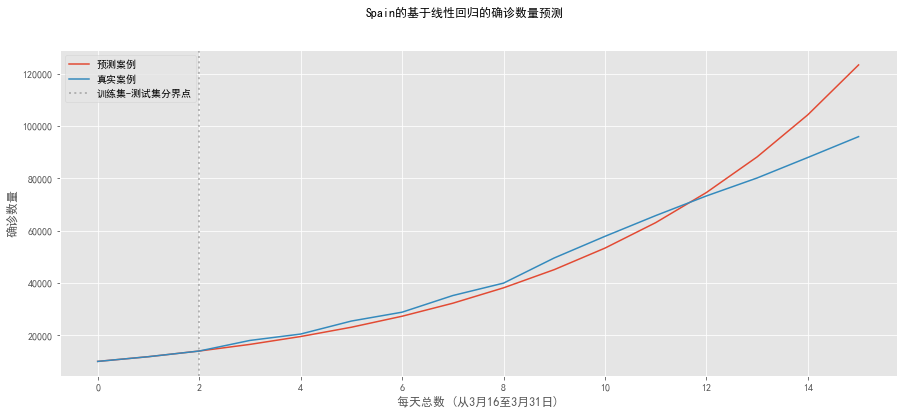